
Skew-T_SAJESS_BASIC_LAYOUT_TEMPLATE
==========================


#### KEY TO FIGURE:
```
Solid red = Temperature (degC)
Solid green = Dewpoint (degC)
Dashed light orange/red = Dry adiabats
Dashed light green = Moist adiabats
Dashed light blue = isohumes (unitless (g/g), at values[0.0004, 0.001, 0.002, 0.004, 0.007, 0.01,
                          0.016, 0.024, 0.032])
Dashed purple line = 0 degC isotherm                       
Solid black = parcel profile
Back dot = Lifting condesation level (LCL)
Blue shading = Convective Inhibition (CIN)
Red shading = Convevtive Available Potential Energy (CAPE)

Use the Associated _SUMMARY.txt file to retrive information regarding each launch
```


In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

from datetime import datetime, timedelta
import os                                  # Used to convert png to other format
import rpnpy.librmn.all as rmn             # Module to read RPN files
from rpnpy.rpndate import RPNDate, RPNDateRange
from fstd2nc.mixins.dates import stamp2datetime

%matplotlib inline
plt.style.use('seaborn-white')

## Files

In [95]:
# the TSPOTINT is the file that has data every 10sec and therefore produces the most detailed figure
f = '/instruments/SAJESS/MustTrailer/soundings/2021_04/master'
ff = 'SAJESS_SOUNDING_20210423_11'
path = f'{f}/{ff}/SAJESS_SOUNDING_20210423_11_TSPOTINT.txt'
df = pd.read_fwf(path,
                 header=0, skiprows=(1,2), infer_nrows=1000)

df['Timestamp'] = df.UTC_Date + ' ' + df.UTC_Time
df.Timestamp = pd.to_datetime(df.Timestamp, infer_datetime_format=True)
df3 = df.set_index('Timestamp')

In [96]:
# getting the lat / lon for each altitude
f = '/instruments/SAJESS/MustTrailer/soundings/2021_04/master'
#ff = 'SAJESS_SOUNDING_20210422_02'
ff = 'SAJESS_SOUNDING_20210423_11'
#path = f'SAJESS_SOUNDING_20210421_17.dat'
path = f'{f}/{ff}/SAJESS_SOUNDING_20210423_11.dat'
# SAJESS_SOUNDING_20210421_17
# SAJESS_SOUNDING_20210421_20
# SAJESS_SOUNDING_20210421_20-1
# SAJESS_SOUNDING_20210421_23
df2 = pd.read_csv(path, header=0, index_col=False,parse_dates=[0], infer_datetime_format=True, 
                 na_values=['999999999.000','9999999999'])#, 
aux = df2.drop(columns=['Fl Sec', 'Az', 'El', 'Az Tr Offs', 'El Tr Offs', 'Sys V', 'Sys I', 'Az I', 'El I', 'MCU Stat', 'SCA Stat', 'SAA BIT', 'MCU BIT', 'SCA BIT', 'CDU1 BIT', 'CDU2 BIT'])
#aux = aux.dropna(thresh=12)
#aux = aux.dropna()
#aux = aux.fillna(method="ffill")
aux['Timestamp'] = pd.to_datetime(aux['Date+Time'])
aux['Timestamp2'] = pd.to_datetime(aux['Date+Time'])
aux2 = aux[['Timestamp','Lat', 'Long', 'Alt', 'Date+Time', 'TAir', 'Timestamp2']]
aux2 = aux2.interpolate().dropna()
aux2 = aux2.set_index('Timestamp')


In [97]:
# Merging the two files so I can have the lat lon for each row
result = pd.concat([df3, aux2], axis=1, join='inner')

## Assign units to individual variables
Note that we convert the wind speed from m/s to knots here to conform to WMO wind barb convention

In [98]:
p = result['Press'].values * units.hPa
T = result['Temp'].values * units.degC
RH = result['RelHum'].values * units.percent

wind_speed = result['WSpeed'].values * units.meter / units.second
wind_speed_knots = wind_speed.to(units.knot)
wind_dir = result['WDirn'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed_knots, wind_dir)
Td = result['DP'].values * units.degC

In [99]:
# Read the model
'''
1) Get the date of the soundings file
2) Open the model file. Get the levels
3) Get the vars (TT, GZ, HU, HR, UU, VV, Pressure). 
4) Sort the levels
5) For each lat/lon/height in the soundings file, get the relative point in the model
6) Plot the skew-P graph
'''
f_hrdps = '/chinook/cruman/Data/HRDPS_SAJESS'
y = 2021
m = 4
d = 22
hour=0
typ = 'model'
filename_1 = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_035_zoom" 
filename_2 = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_036_zoom" 
# Soundings initial hour
s_d = 35

dt = datetime(y, m, d, hour) + timedelta(hours=s_d)

# 2 and 3 and 4
data_TT, dates, height_TT = readVerticalRecords("TT", RPNDate(dt), filename_1)
data_GZ, dates, height_GZ = readVerticalRecords("GZ", RPNDate(dt), filename_1)
data_HU, dates, height_HU = readVerticalRecords("HU", RPNDate(dt), filename_1)
data_PX, dates, height_PX = readVerticalRecords("PX", RPNDate(dt), filename_1)
data_HR, dates, height_HR = readVerticalRecords("HR", RPNDate(dt), filename_1)
data_UU, dates, height_UU = readVerticalRecords("UU", RPNDate(dt), filename_1)
data_VV, dates, height_VV = readVerticalRecords("VV", RPNDate(dt), filename_1)

# 5
lats2d, lons2d = getLatLon(filename_1, 'TT')
#i, j = geo_idx([lat,lon], np.array([lat2d,lon2d]))
# For each line in the df dataframe, get the lat lon Alt and get the equivalent value in the model.
alt_0 = df.iloc[0]['Alt_MSL']

aux1 = []
aux2 = []
height_1 = data_GZ[0::2] # Wind
height_2 = data_GZ[1::2] # Others
pressure_1 = data_PX[0::2] # Wind
pressure_2 = data_PX[1::2] # Others
check = True
for index, row in result.iterrows():
    lat = row['Lat']
    lon = row['Long']
    alt = row['Alt_AGL'] #- alt_0
    # if time is greater than 30min, reload the data with the new file
    if row['Timestamp2'].hour == 2 and row['Timestamp2'].minute > 30 and check:
        check = False
        dt = datetime(y, m, d, hour) + timedelta(hours=s_d+1)
        data_TT, dates, height_TT = readVerticalRecords("TT", RPNDate(dt), filename_2)
        data_GZ, dates, height_GZ = readVerticalRecords("GZ", RPNDate(dt), filename_2)
        data_HU, dates, height_HU = readVerticalRecords("HU", RPNDate(dt), filename_2)
        data_PX, dates, height_PX = readVerticalRecords("PX", RPNDate(dt), filename_2)
        data_HR, dates, height_HR = readVerticalRecords("HR", RPNDate(dt), filename_2)
        data_UU, dates, height_UU = readVerticalRecords("UU", RPNDate(dt), filename_2)
        data_VV, dates, height_VV = readVerticalRecords("VV", RPNDate(dt), filename_2)
        height_1 = data_GZ[0::2] # Wind
        height_2 = data_GZ[1::2] # Others
        pressure_1 = data_PX[0::2] # Wind
        pressure_2 = data_PX[1::2] # Others
        
    i, j = geo_idx([lat,lon], np.array([lats2d,lons2d]))
    z1 = np.abs(height_1[:,i,j] - alt).argmin()
    z2 = np.abs(height_2[:,i,j] - alt).argmin()    
    aux1.append([row['Timestamp2'], height_1[z1,i,j], data_TT[z1,i,j], data_HU[z1,i,j], pressure_1[z1,i,j], data_HR[z1,i,j]])
    aux2.append([row['Timestamp2'], height_2[z2,i,j], pressure_2[z2,i,j], data_UU[z2,i,j], data_VV[z2,i,j]])

df_model1 = pd.DataFrame(aux1, columns=['Timestamp2','GZ_1', 'TT', 'HU', 'PX_1', 'HR'])
df_model2 = pd.DataFrame(aux2, columns=['Timestamp2','GZ_2', 'PX_2', 'UU', 'VV'])

aux1 = df_model1.drop(columns=['Timestamp2'])
test1 = aux1.drop_duplicates()

aux2 = df_model2.drop(columns=['Timestamp2'])
test2 = aux2.drop_duplicates()

In [100]:
p_m = test1['PX_1'].values * units.hPa
T_m = test1['TT'].values * units.degC
RH_m = test1['HR'].values*100 * units.percent

u_m = (test2['UU'].values * units.meter / units.second).to(units.knot)
v_m = (test2['VV'].values * units.meter / units.second).to(units.knot)
#wind_speed_m = result['WSpeed'].values * units.meter / units.second
#wind_speed_knots_m = wind_speed.to(units.knot)
#wind_dir_m = result['WDirn'].values * units.degrees
#u_m, v_m = mpcalc.wind_components(wind_speed_knots_m, wind_dir_m)
Td_m = mpcalc.dewpoint_from_relative_humidity(T_m, RH_m)
#Td_m = result['DP'].values * units.degC

## Calculate dewpoint

In [5]:
#Td = mpcalc.dewpoint_rh(T, RH)

## Plot skew-T

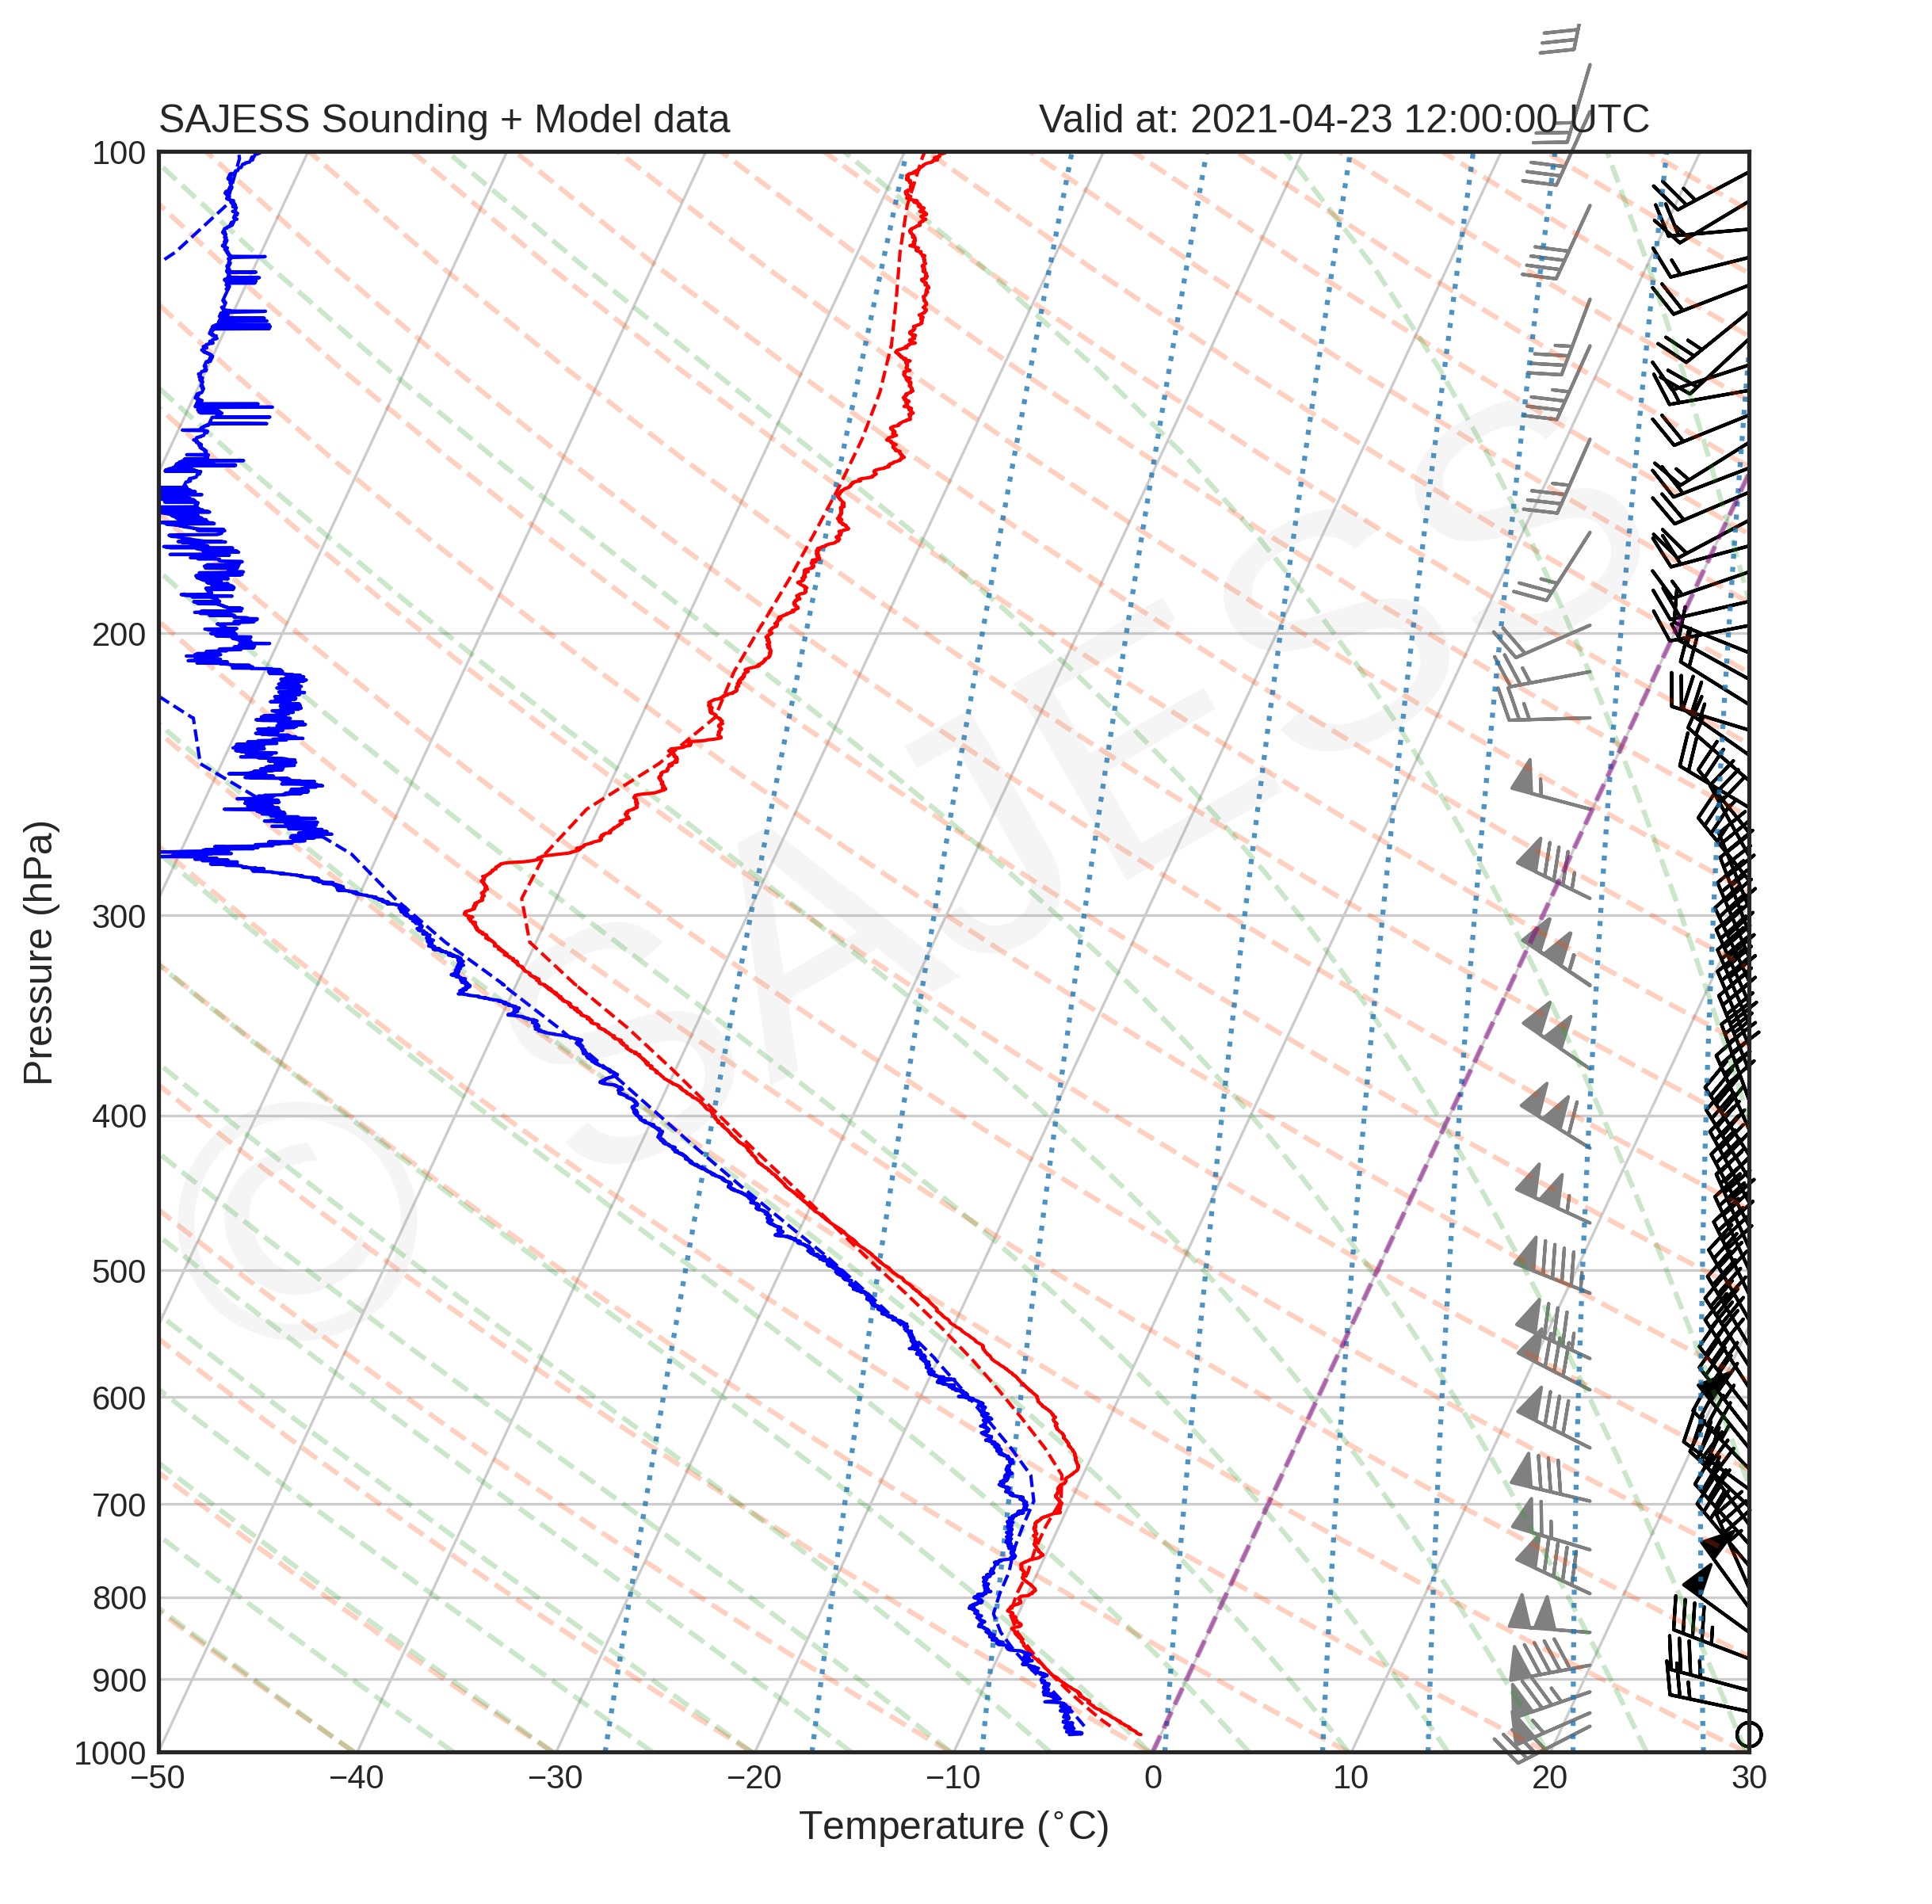

In [101]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(12, 8), dpi=300, facecolor='white')
fs=12

# Grid for plots
gs = gridspec.GridSpec(3, 3)
skew = SkewT(fig, rotation=25, subplot=gs[:, :2])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'red', lw=1.)
skew.plot(p_m, T_m, 'red', lw=1., linestyle='dashed')
skew.plot(p, Td, 'blue', lw=1.)
skew.plot(p_m, Td_m, 'blue', lw=1., linestyle='dashed',)

# vertically space barbs for clarity
spacing = 100
upper_lim = df.Press[df.Press>100]
upper_ind = upper_lim.index[-1]
utrim = u[0:upper_ind]
vtrim = v[0:upper_ind]
ptrim = p[0:upper_ind]
skew.plot_barbs(ptrim[::spacing], utrim[::spacing], vtrim[::spacing], color='black')

spacing = 2
upper_lim = test2.PX_2[test2.PX_2>100]
upper_ind = upper_lim.index[-1]
utrim_m = u_m[0:upper_ind]
vtrim_m = v_m[0:upper_ind]
ptrim_m = p_m[0:upper_ind]
if utrim_m.shape[0] == 103:
    skew.plot_barbs(ptrim_m[::spacing], utrim_m[1::spacing], vtrim_m[1::spacing], color='gray', xloc=0.9)
else:
    skew.plot_barbs(ptrim_m[::spacing], utrim_m[::spacing], vtrim_m[::spacing], color='gray', xloc=0.9)


skew.ax.set_ylim(1000, 100)


# plot LCL
#lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
#skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot parcel profile
#prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
#skew.plot(p, prof, 'k') 

# if CAPE and/or CIN are > 0, add shading
#skew.shade_cin(p, T, prof, alpha=.1)
#skew.shade_cape(p, T, prof, alpha=0.1)

# Add the relevant special lines
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# 0 degC isotherm
skew.ax.axvline(0, color='purple', linestyle='--', linewidth=1.5, alpha=.5)

# Good bounds for aspect ratio
skew.ax.set_xlim(-50,30)

# Create a hodograph
#ax = fig.add_subplot(gs[0, -1])
#h = Hodograph(ax, component_range=100.)
#h.add_grid(increment=20)
#h.plot(u, v, linewidth=1., color='green')

# Add some descriptive titles
skew.ax.set_title(r'SAJESS Sounding + Model data', loc='left', fontsize=fs)
skew.ax.set_title(r'Valid at: {} UTC         '.format(result.Timestamp2.iloc[0].ceil('H')), loc='right', fontsize=fs)
skew.ax.set_ylabel(r'Pressure (hPa)', fontsize=fs)
skew.ax.set_xlabel(r'Temperature ($^{\circ}$C)', fontsize=fs)

skew.ax.text(-32.5,300, r'$\copyright$ SAJESS',fontsize=100, color='gray', alpha=0.08, ha='center', va='center', rotation='30')

# Show the plot
plt.tight_layout()
#plt.show()
#fig.savefig('../../Figures/Skew-T-plots/SAJESS_SkewT_20211203_0300UTC.png', format='png', bbox_inches='tight')
plt.savefig(f'soundings_{y}_{m}_{d}_{s_d}.png')

In [50]:
def interpPressure(pressure, pressure_levels, data, interp='linear'):
  """
  Interpolate data to custom pressure levels
  pressure: Original pressure level
  pressure_levels: Custom pressure level
  data: Original variable to be interpolated to custom pressure level
  returns: new_val, the original variable interpolated.
  """
  from scipy import interpolate

  f = interpolate.interp1d(pressure, data, kind=interp)
  
  new_val = f(pressure_levels)

  return new_val

def geo_idx(dd, dd_array, type="lat"):
  '''
    search for nearest decimal degree in an array of decimal degrees and return the index.
    np.argmin returns the indices of minium value along an axis.
    so subtract dd from all values in dd_array, take absolute value and find index of minimum.
    
    Differentiate between 2-D and 1-D lat/lon arrays.
    for 2-D arrays, should receive values in this format: dd=[lat, lon], dd_array=[lats2d,lons2d]
  '''
  if type == "lon" and len(dd_array.shape) == 1:
    dd_array = np.where(dd_array <= 180, dd_array, dd_array - 360)

  if (len(dd_array.shape) < 2):
    geo_idx = (np.abs(dd_array - dd)).argmin()
  else:
    if (dd_array[1] < 0).any():
      dd_array[1] = np.where(dd_array[1] <= 180, dd_array[1], dd_array[1] - 360)

    a = abs( dd_array[0]-dd[0] ) + abs(  np.where(dd_array[1] <= 180, dd_array[1], dd_array[1] - 360) - dd[1] )
    i,j = np.unravel_index(a.argmin(), a.shape)
    geo_idx = [i,j]

  return geo_idx

def readVerticalRecords(varname, datev, filename):
    fid = rmn.fstopenall(filename,rmn.FST_RO)
    
    record_list = []
    record_date_list = []
    #record_ip = []
    record_ip1 = []
    record_ip1_type = []
    
    for k in rmn.fstinl(fid, nomvar=varname, datev=datev.datev):
        #print(rmn.fstluk(k))
        record_list.append(rmn.fstluk(k)['d'])                
        record_date_list.append(stamp2datetime(rmn.fstluk(k)['datev']))
        ip1=rmn.fstluk(k)['ip1']
        ip2=rmn.fstluk(k)['ip2']
        ip3=rmn.fstluk(k)['ip3']
        rp1, rp2, rp3 = rmn.DecodeIp(ip1, ip2, ip3)    
        #record_ip.append([(rp1.v1, rmn.kindToString(rp1.kind)), (rp2.v1, rmn.kindToString(rp2.kind)), (rp3.v1, rmn.kindToString(rp3.kind))])
        record_ip1.append(rp1.v1)
        record_ip1_type.append(rmn.kindToString(rp1.kind))            
        
    #print(record_date_list)
    
    r_data = np.array(record_list)    
    r_date = np.array(record_date_list)
    r_height = np.array(record_ip1)    
    
    # Sort by height
    idx = np.argsort(r_height)
    r_data = r_data[idx][::-1]
    r_date = r_date[idx][::-1]
    r_height = r_height[idx][::-1]    

    # Dropping the first level. I only want the model levels
    return r_data[1:], r_date[1:], r_height[1:]

def getLatLon(filename, var):
    fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file    
    rec = rmn.fstlir(fid,nomvar=var)        # Read the full record of variable 'varname'
    field = rec['d']#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname' 
    mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
    latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information

    lat2d = latlondict['lat']#[i1:i2,j1:j2]                     # Assign 'lat' to 2-D latitude field
    lon2d = latlondict['lon']#[i1:i2,j1:j2]                    # Assign 'lon' to 2-D longitude field
    
    return lat2d, lon2d